In [67]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [76]:
# Step 1: Load the dataset
# You can download the dataset from: https://exoplanetarchive.ipac.caltech.edu
url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+pscomppars&format=csv"
original_data = pd.read_csv(url)

In [77]:
data = original_data

Planetary Parameters

    pl_name: Name of the exoplanet.
    pl_rade: Planetary radius in Earth radii.
    pl_bmasse: Planetary mass in Earth masses.
    pl_orbper: Orbital period in days.
    pl_orbsmax: Orbital semi-major axis in AU (distance from the star).
    pl_orbeccen: Orbital eccentricity (circularity of orbit).
    pl_eqt: Planetary equilibrium temperature (useful for habitability analysis).
    pl_dens: Planetary density in g/cm³ (can distinguish rocky vs. gaseous planets).
    
Stellar Parameters

    st_teff: Stellar effective temperature in Kelvin.
    st_mass: Stellar mass in Solar masses.
    st_rad: Stellar radius in Solar radii.
    st_lum: Stellar luminosity in Solar luminosities.
    st_age: Stellar age in Gyr (billions of years).
    st_logg: Stellar surface gravity (logarithmic).
    
Orbital and Detection Parameters

    sy_dist: Distance to the system in parsecs (useful for prioritizing nearby systems for further study).
    pl_insol: Insolation received by the planet in Earth units (correlates with temperature and habitability).
    pl_trandep: Transit depth, related to planet size.
    pl_trandur: Transit duration in hours (helps infer planet size and orbit).
    
Host Star Metallicity

    st_metfe: Stellar metallicity [Fe/H] (higher metallicity stars tend to form more planets).
    
Habitability-Relevant Columns

For a habitability-focused analysis, you may prioritize:

    pl_orbper and pl_orbsmax: Indicators of whether the planet is in the habitable zone.
    st_teff and st_lum: Define the boundaries of the habitable zone based on stellar characteristics.
    pl_eqt: Approximation of surface temperature.
    pl_insol: Planet's insolation flux (helps determine if liquid water could exist).
    pl_rade and pl_bmasse: Classify planets as rocky (Earth-like) or gaseous (Neptune-like).

In [78]:
data.shape

(5788, 682)

In [79]:
# Step 2: Data Preprocessing
# Keep only relevant columns and drop rows with missing values

# Rename columns with clearer names
data.rename(columns={
    'pl_name': 'Planet Name',
    'pl_rade': 'Planet Radius (Earth radii)',
    'pl_bmasse': 'Planet Mass (Earth masses)',
    'pl_orbper': 'Orbital Period (days)',
    'pl_orbsmax': 'Orbital Semi-Major Axis (AU)',
    'pl_orbeccen': 'Orbital Eccentricity',
    'pl_eqt': 'Planet Temperature (K)',
    'pl_dens': 'Planet Density (g/cm³)',
    'st_teff': 'Star Temperature (K)',
    'st_mass': 'Star Mass (Solar masses)',
    'st_rad': 'Star Radius (Solar radii)',
    'st_lum': 'Star Luminosity (Solar luminosities)',
    'st_age': 'Star Age (Gyr)',
    'st_logg': 'Star Surface Gravity',
    'sy_dist': 'Star Distance (pc)',
    'pl_insol': 'Planet Insolation (Earth units)',
    'pl_trandep': 'Transit Depth',
    'pl_trandur': 'Transit Duration (hours)'
}, inplace=True)



In [90]:
# Define habitability (based on a simple rule for this example)
def is_habitable(row):
    # Let's consider these simplified conditions for habitability
    # 1. Orbital Period between 1-300 days (in the habitable zone for many stars)
    # 2. Stellar Temperature between 3000 K - 6000 K (Suitable for hosting life)
    # 3. Planet Insolation between 0.5 - 1.5 (Earth-like insolation)
    if (
        1 <= row['Orbital Period (days)'] <= 300 and 
        3000 <= row['Star Temperature (K)'] <= 6000 and
        0.5 <= row['Planet Insolation (Earth units)'] <= 1.5
    ):
        return 1  # Habitable
    else:
        return 0  # Not Habitable

In [91]:
features = [
    'Orbital Period (days)', 'Planet Radius (Earth radii)', 'Planet Mass (Earth masses)', 
    'Orbital Eccentricity', 'Planet Temperature (K)', 'Star Temperature (K)', 
    'Star Mass (Solar masses)', 'Star Radius (Solar radii)', 'Star Luminosity (Solar luminosities)', 
    'Planet Insolation (Earth units)', 'Star Age (Gyr)', 
    'Star Surface Gravity', 'Star Distance (pc)', 'Planet Density (g/cm³)', 'Transit Depth', 
    'Transit Duration (hours)', 'Orbital Semi-Major Axis (AU)'
]

data = data[features].dropna()

data['Habitability'] = data.apply(is_habitable, axis=1)

all_features = features + ['Habitability']

# Features and target
X = data[features]
y = data['Habitability']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [92]:
data.head()

Orbital Period (days)  Planet Radius (Earth radii)  \
1                3.609309                        3.730   
3                7.493134                        2.760   
10              56.008190                        4.230   
11               7.450724                        1.521   
12               1.467121                        1.289   

    Planet Mass (Earth masses)  Orbital Eccentricity  Planet Temperature (K)  \
1                       13.400               0.00000                  1092.0   
3                       13.200               0.00000                   651.0   
10                       7.943               0.12030                   585.2   
11                       1.940               0.07400                   416.0   
12                       2.770               0.00086                   696.3   

    Star Temperature (K)  Star Mass (Solar masses)  Star Radius (Solar radii)  \
1                 5635.0                      0.94                       0.93   
3                 4227.0                      0.68                       0.67   
10                6120.0                      1.26                       1.45   
11                3415.0                      0.27                       0.30   
12                3317.0                      0.31                       0.32   

    Star Luminosity (Solar luminosities)  Planet Insolation (Earth units)  \
1                                 -0.116                           419.91   
3                                 -0.889                            29.81   
10                                 0.456                            29.95   
11                                -1.948                             5.01   
12                                -1.939                            39.20   

    Star Age (Gyr)  Star Surface Gravity  Star Distance (pc)  \
1             4.47                  4.49          1122.48000   
3             6.70                  4.57            73.59770   
10            1.10                  4.13           139.61100   
11            0.80                  4.86            10.61940   
12            4.00                  4.91             8.07426   

    Planet Density (g/cm³)  Transit Depth  Transit Duration (hours)  \
1                    1.420        0.15834                    1.7448   
3                    3.450        0.14210                    1.9700   
10                   0.577        0.08340                    8.9730   
11                   2.950        0.15420                    0.8400   
12                   6.660        0.13871                    1.0158   

    Orbital Semi-Major Axis (AU)  Habitability  
1                        0.04550             0  
3                        0.06570             0  
10                       0.30800             0  
11                       0.04860             0  
12                       0.01714             0

In [93]:
data.describe()

Orbital Period (days)  Planet Radius (Earth radii)  \
count            3403.000000                  3403.000000   
mean               24.011408                     4.196046   
std                54.301510                     4.476232   
min                 0.280324                     0.310000   
25%                 4.067446                     1.600000   
50%                 8.990889                     2.390000   
75%                21.088993                     3.669500   
max              1071.232050                    25.000000   

       Planet Mass (Earth masses)  Orbital Eccentricity  \
count                 3403.000000           3403.000000   
mean                    96.034509              0.029588   
std                    380.323924              0.092161   
min                      0.037400              0.000000   
25%                      3.290000              0.000000   
50%                      6.690000              0.000000   
75%                     15.600000              0.000000   
max                   7310.053360              0.920000   

       Planet Temperature (K)  Star Temperature (K)  Star Mass (Solar masses)  \
count             3403.000000           3403.000000               3403.000000   
mean               922.744212           5497.715275                  0.964287   
std                447.234713            723.649691                  0.246172   
min                134.400000           2566.000000                  0.090000   
25%                587.884796           5180.000000                  0.840000   
50%                833.000000           5650.000000                  0.960000   
75%               1167.000000           5959.500000                  1.080000   
max               4050.000000          10170.000000                  2.780000   

       Star Radius (Solar radii)  Star Luminosity (Solar luminosities)  \
count                3403.000000                           3403.000000   
mean                    1.042028                             -0.101457   
std                     0.414145                              0.572507   
min                     0.010000                             -4.120000   
25%                     0.800000                             -0.396000   
50%                     0.960000                             -0.044000   
75%                     1.210000                              0.303000   
max                     6.300000                              1.724000   

       Planet Insolation (Earth units)  Star Age (Gyr)  Star Surface Gravity  \
count                      3403.000000     3403.000000           3403.000000   
mean                        440.927714        4.339733              4.432897   
std                        1378.208035        2.952579              0.222325   
min                           0.100000        0.000000              2.950000   
25%                          27.720000        2.500000              4.310000   
50%                         110.510000        3.920000              4.460000   
75%                         415.810000        5.010000              4.560000   
max                       44900.000000       15.900000              7.920000   

       Star Distance (pc)  Planet Density (g/cm³)  Transit Depth  \
count         3403.000000             3403.000000    3403.000000   
mean           677.466508                4.531638       0.282611   
std            466.663002               35.826736       1.131646   
min              6.531270                0.030000       0.001220   
25%            320.819500                1.670000       0.026995   
50%            610.326000                2.740000       0.061370   
75%            935.191000                4.605000       0.150995   
max           3460.510000             2000.000000      56.650000   

       Transit Duration (hours)  Orbital Semi-Major Axis (AU)  Habitability  
count               3403.000000                   3403.000000   3403.000000  
mean                   3.987264       

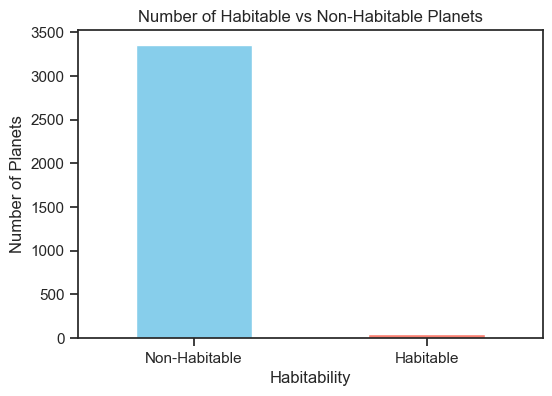

In [94]:
# Count the number of habitable and non-habitable planets
habitability_counts = data['Habitability'].value_counts()

# Plot the bar chart
plt.figure(figsize=(6, 4))
habitability_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Number of Habitable vs Non-Habitable Planets')
plt.xlabel('Habitability')
plt.ylabel('Number of Planets')
plt.xticks([0, 1], ['Non-Habitable', 'Habitable'], rotation=0)
plt.show()

In [95]:
habitability_counts

Habitability
0    3358
1      45
Name: count, dtype: int64

C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\se

C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\se

C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\se

C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\se

C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\se

C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\se

C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\s3nt1\Documents\gitRepos\exoplanet-classification\venv\lib\site-packages\se

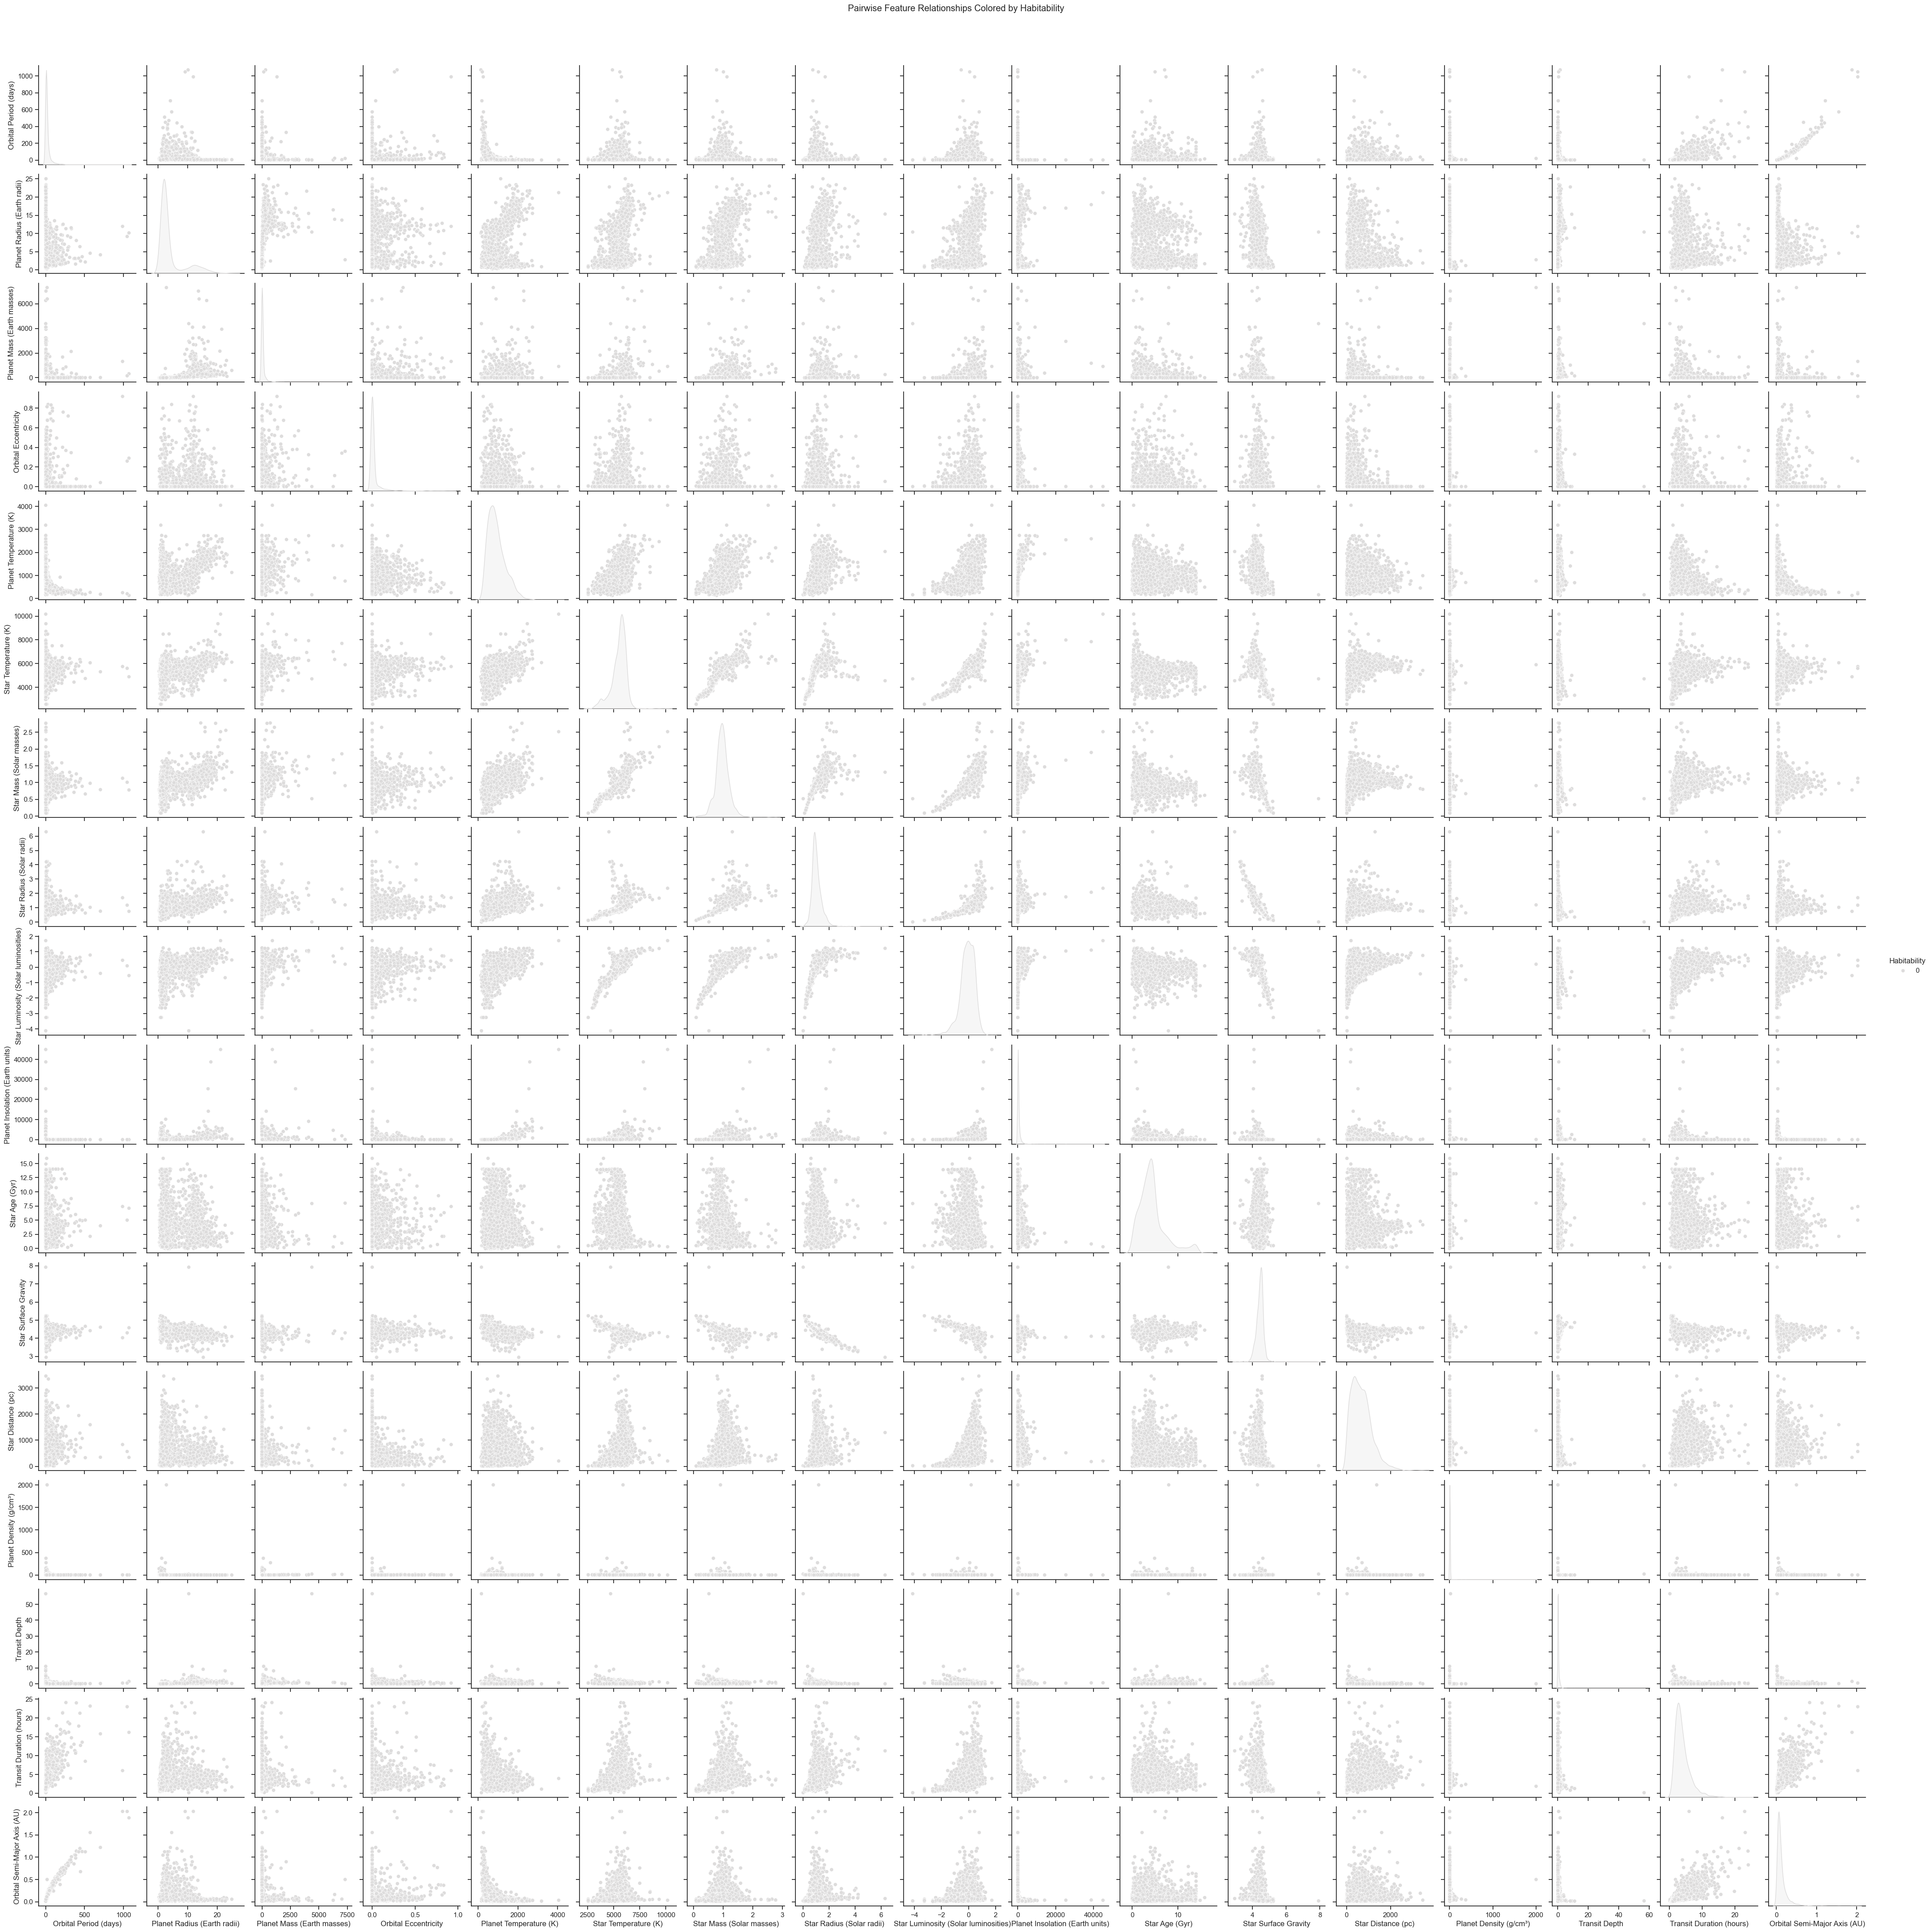

In [86]:
data_subset = data[all_features]

# Create a Pairplot
sns.set(style="ticks", color_codes=True)
pair_plot = sns.pairplot(data_subset, hue='Habitability', palette='coolwarm', diag_kind='kde', markers=["o", "s"])
pair_plot.fig.suptitle("Pairwise Feature Relationships Colored by Habitability", y=1.02)
plt.show()

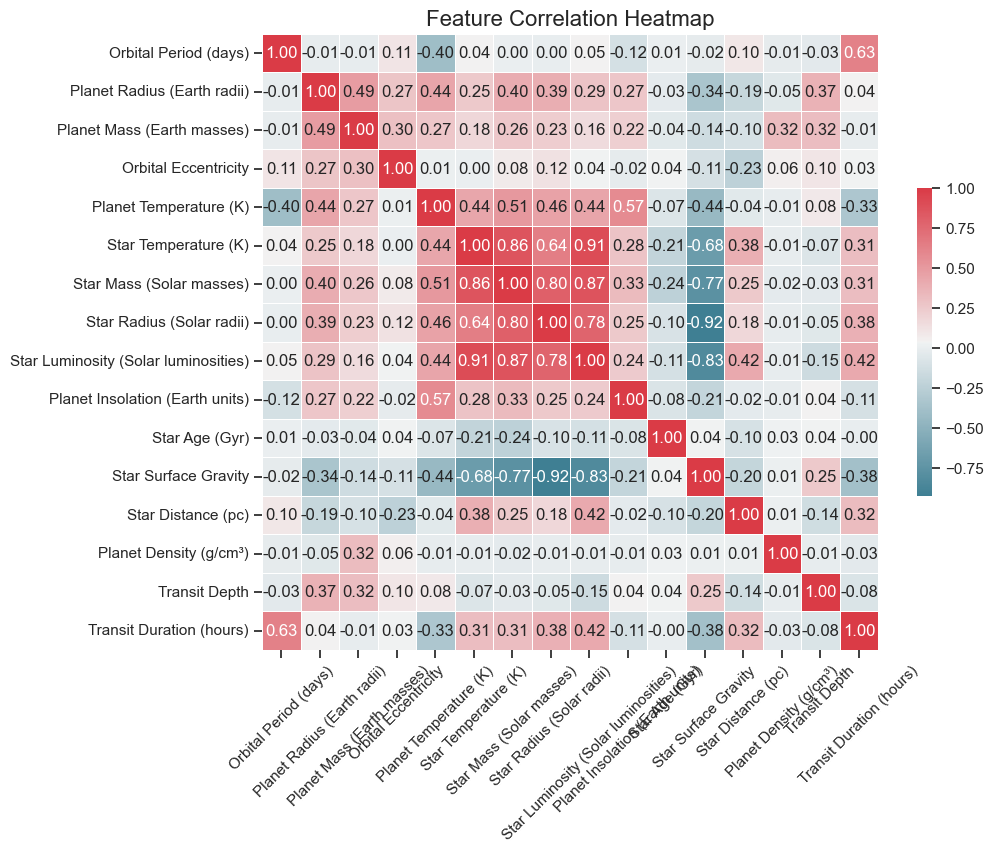

In [87]:
# Compute the correlation matrix
corr_matrix = data[features[:-1]].corr()  # Exclude 'Habitability' for correlation

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=cmap, linewidths=.5, square=True, cbar_kws={"shrink": .5})
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


Random Forest - Accuracy: 0.9985315712187959
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       672
           1       1.00      0.89      0.94         9

    accuracy                           1.00       681
   macro avg       1.00      0.94      0.97       681
weighted avg       1.00      1.00      1.00       681


SVM - Accuracy: 0.9970631424375918
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       672
           1       0.82      1.00      0.90         9

    accuracy                           1.00       681
   macro avg       0.91      1.00      0.95       681
weighted avg       1.00      1.00      1.00       681


Neural Network (MLP) - Accuracy: 0.986784140969163
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       672
           1       0.50      0.11      0.18         9

    accuracy                           0.99     

C:\Users\s3nt1\AppData\Local\Temp\ipykernel_30536\4239914412.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette='viridis')


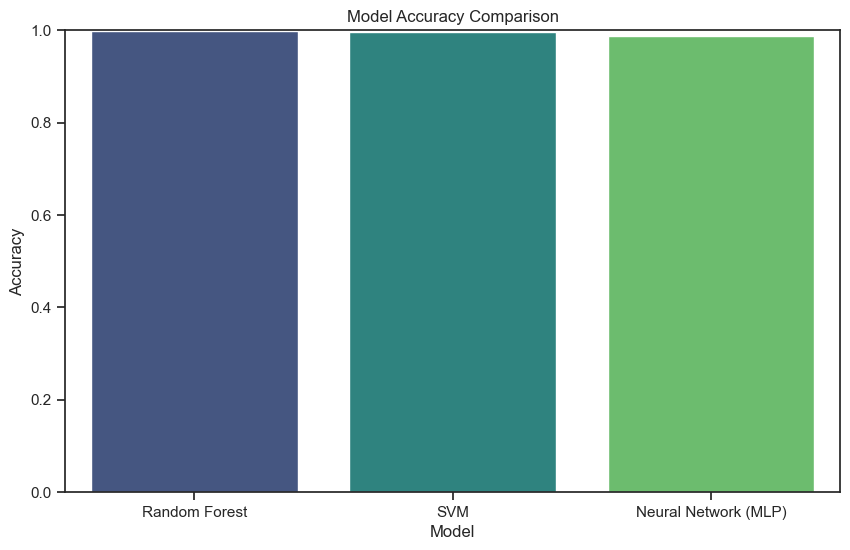

In [96]:
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'Neural Network (MLP)': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

# Train and evaluate models
results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, output_dict=True)
    
    results[model_name] = {
        'accuracy': accuracy,
        'classification_report': classification_rep
    }

    print(f"\n{model_name} - Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))

# Plotting the comparison of model accuracies
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]

plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracies, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.show()

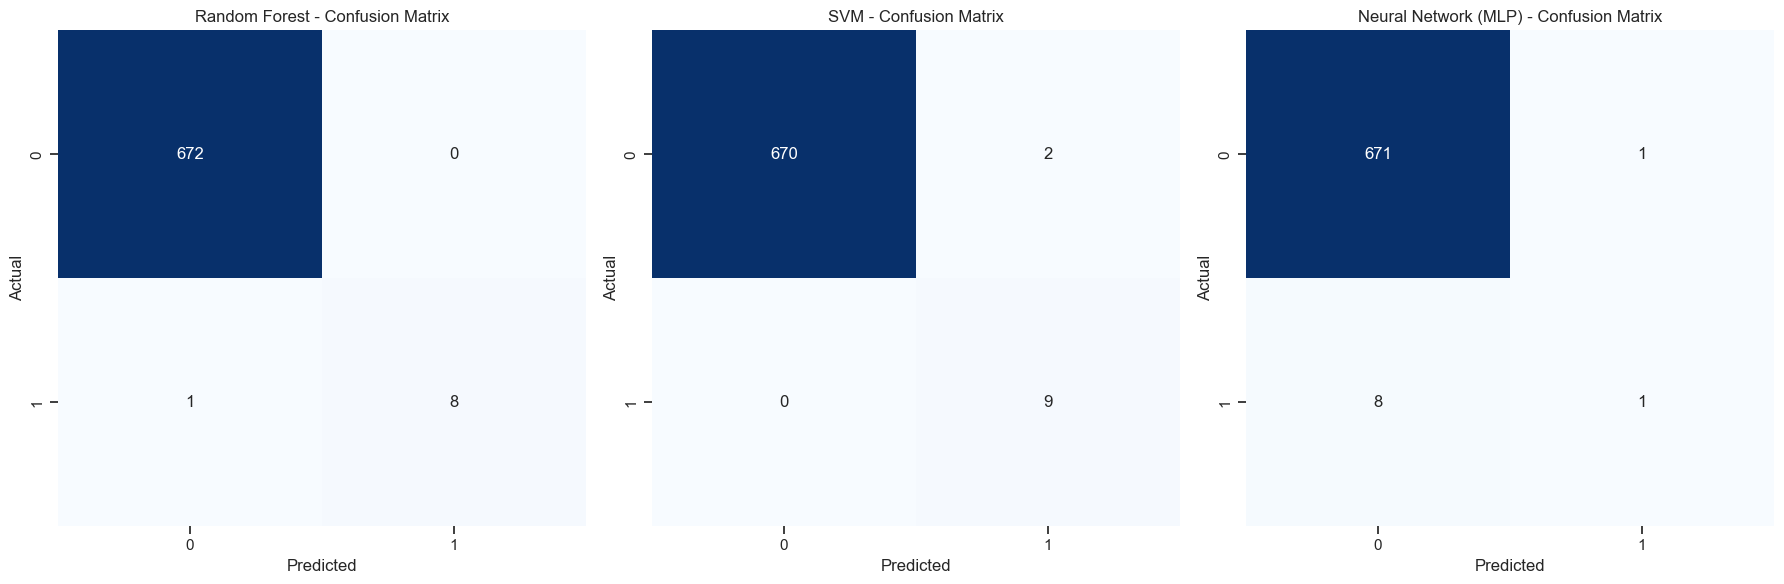

In [97]:
# Visualizing confusion matrices
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, model_name in enumerate(model_names):
    cm = confusion_matrix(y_test, models[model_name].predict(X_test))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axs[i], cbar=False)
    axs[i].set_title(f'{model_name} - Confusion Matrix')
    axs[i].set_xlabel('Predicted')
    axs[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

### Random Forest

In [100]:
def plot_feature_importance(feature_names, importances, model_name):
    sorted_indices = np.argsort(importances)[::-1]
    sorted_features = np.array(features)[sorted_indices]
    sorted_importances = importances[sorted_indices]

    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_importances, color="skyblue")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title(f"{model_name} Feature Importance")
    plt.gca().invert_yaxis()  # To display the most important feature at the top
    plt.show()

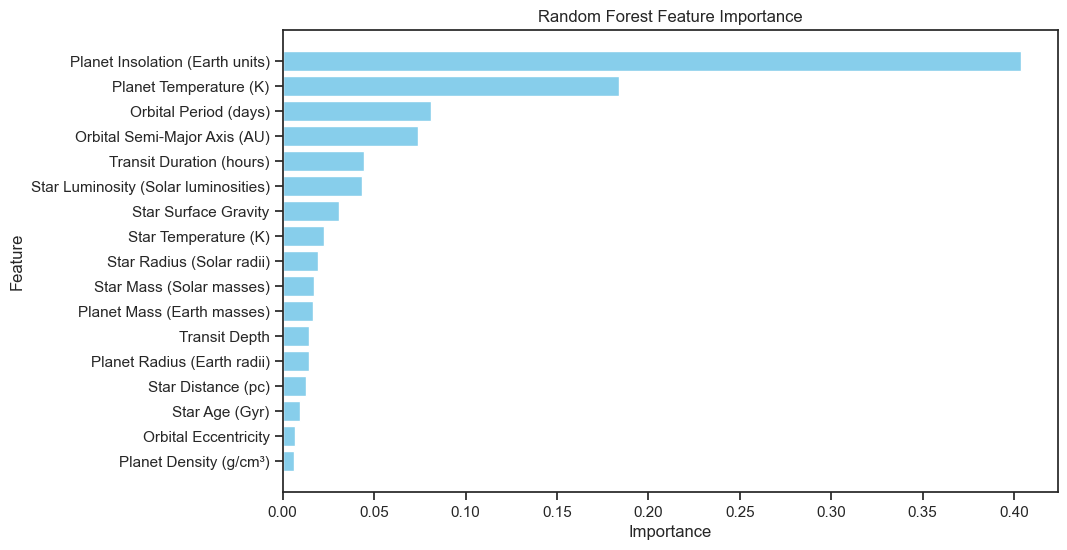

In [101]:
# Random Forest Feature Importance
rf_importances = models['Random Forest'].feature_importances_
plot_feature_importance(feature_names, rf_importances, "Random Forest")

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       840
           1       0.99      1.00      0.99       148

    accuracy                           1.00       988
   macro avg       0.99      1.00      1.00       988
weighted avg       1.00      1.00      1.00       988

Confusion Matrix:
 [[838   2]
 [  0 148]]


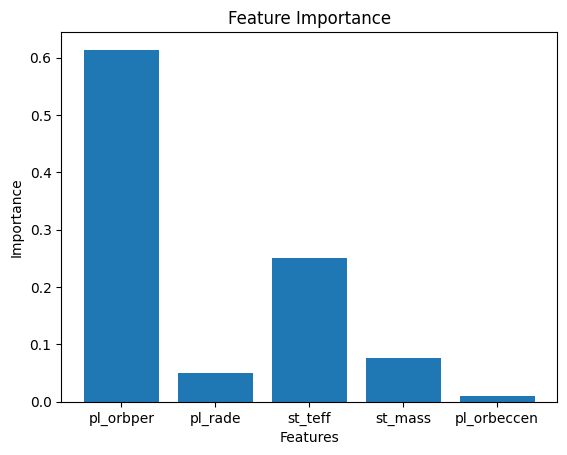

In [14]:
# Step 5: Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 6: Model Evaluation
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Step 7: Feature Importance
feature_importance = model.feature_importances_
plt.bar(X.columns, feature_importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()


### SVM

### Neural Network